## Кластеризация твитов о благотворительных фондах по темам

## 

In [1]:
import pandas as pd, os
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml import KMeans
from cuml import UMAP
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian') )
print('RAPIDS',cudf.__version__)

RAPIDS 21.10.01


In [2]:
stopwords.update(['вольное','фонд','дело','яхты','эпизода'])

### Вольное дело

In [3]:
"""Загружаем данные """
data = pd.read_csv('../input/top20-russian-fonds-tweets/data_marked.csv')
fond_data = data[data.fond_name == '"Вольное дело"']
train_names = fond_data.id.to_list()
train_texts = fond_data.tweet.to_list()
train_text_df = cudf.DataFrame({'id': train_names, 'text': train_texts})
train_text_df.head()

,id,text
0,874216234463768576,@svetlyak37
1,874213898748133376,@svetlyak37
2,656906259518636032,"@svetlyak37 Принимаем заказы, Наши координаты..."
3,1338921861883813888,Студия Либо/Либо и фонд Олега Дерипаска «Вольн...
4,1321844306496421888,Робофест перешел в онлайн-формат Фонд Олега Д...


In [4]:
"""Получение векторных представлений текстов"""

tfidf = TfidfVectorizer(stop_words=stopwords, binary=True, max_features=25_000)
text_embeddings = tfidf.fit_transform(train_text_df.text).toarray()

""" Понижение размерности"""
umap = UMAP()
embed_2d = umap.fit_transform(text_embeddings)
embed_2d = cupy.asnumpy( embed_2d )

#### Кластеризация текстов по темам

In [5]:
n_clusters = 5
kmeans = cuml.KMeans(n_clusters=n_clusters)
kmeans.fit(embed_2d)
train_text_df['cluster'] = kmeans.labels_

#### Визуализация распределения текстов по темам


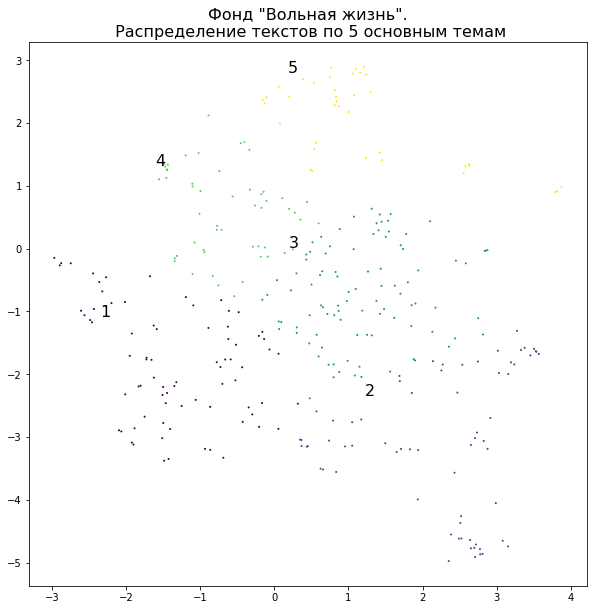

In [6]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=kmeans.labels_)
plt.title(f'Фонд "Вольная жизнь".\n Распределение текстов по {n_clusters} основным темам',size=16)

for k in range(len(centers)):
    mm = cupy.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = cupy.argmax(mm)
    top_word = tfidf.vocabulary_.iloc[ii]
    plt.text(centers[k,0]-1,centers[k,1]+0.75,f'{k+1}',size=16)

plt.show()

#### Примеры текстов для каждой темы. 
Покажем три примера текста для каждой темы. Также отобразим пять самых важных слов для каждой темы.

In [7]:
for k in range(n_clusters):
    mm = cupy.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = cupy.asnumpy( cupy.argsort(mm)[-5:][::-1] )
    top_words = tfidf.vocabulary_.to_array()[ii]
    print('#'*25)
    print(f'### Тема {k+1}')
    print('### Топ 5 Слов',top_words)
    print('#'*25)
    tmp = train_text_df.loc[train_text_df.cluster==k].sample(3, random_state=123)
    for j in range(3):
        txt = tmp.iloc[j,1]
        print('-'*10,f'Пример {j+1}','-'*10)
        print(txt,'\n')

#########################
### Тема 1
### Топ 5 Слов ['олега' 'дерипаска' 'конкурс' 'объявляет' 'мгу']
#########################
---------- Пример 1 ----------
Журнал "Директор школы" и Фонд Олега Дерипаска "Вольное Дело" выбрали 30 лучших директоров российских школ в...   

---------- Пример 2 ----------
Лучшие благотворительные фонды по версии журнала Forbes /  / 7. Фонд «Вольное дело» /  / Год основания: 2008 / Донор: Олег Дерипаска / Бюджет: 685 млн руб. / Итоговый балл: 60,37 /  / Фонд проводит фестиваль научно-технического творчества PROFES..   

---------- Пример 3 ----------
Фонд Олега Дерипаска «Вольное Дело», один из крупнейших в России частных благотворительных фондов, объявляет об открытии первого в Сочи 

#########################
### Тема 2
### Топ 5 Слов ['суд' 'навального' 'дерипаска' 'подает' 'пенсионный']
#########################
---------- Пример 1 ----------
Фонд Навального закликає Австрію заморозити «готель Дерипаски» в Лех-ам-Арльберзі   

---------- Пример 2 ---

### Фонд Тимченко

In [8]:
"""Загружаем данные """
fond_data = data[data.fond_name == 'Фонд Тимченко']
train_names = fond_data.id.to_list()
train_texts = fond_data.tweet.to_list()
train_text_df = cudf.DataFrame({'id': train_names, 'text': train_texts})
train_text_df.head()

,id,text
0,1126162204062114048,«Уютное местечко» — многофункциональная площад...
1,1122891590975000960,История Фонда Елены и Геннадия Тимченко начала...
2,1121451651863326976,Беседы о возрасте – цикл встреч с известными л...
3,1120357438585176064,В переулке мечты города Губахи Пермского края ...
4,1118173948078850048,"Нам всё больше нравится термин «Young Old», и ..."


In [9]:
"""Получение векторных представлений текстов"""

tfidf = TfidfVectorizer(stop_words=stopwords, binary=True, max_features=25_000)
text_embeddings = tfidf.fit_transform(train_text_df.text).toarray()

""" Понижение размерности"""
umap = UMAP()
embed_2d = umap.fit_transform(text_embeddings)
embed_2d = cupy.asnumpy( embed_2d )

In [10]:
n_clusters = 3
kmeans = cuml.KMeans(n_clusters=n_clusters)
kmeans.fit(embed_2d)
train_text_df['cluster'] = kmeans.labels_

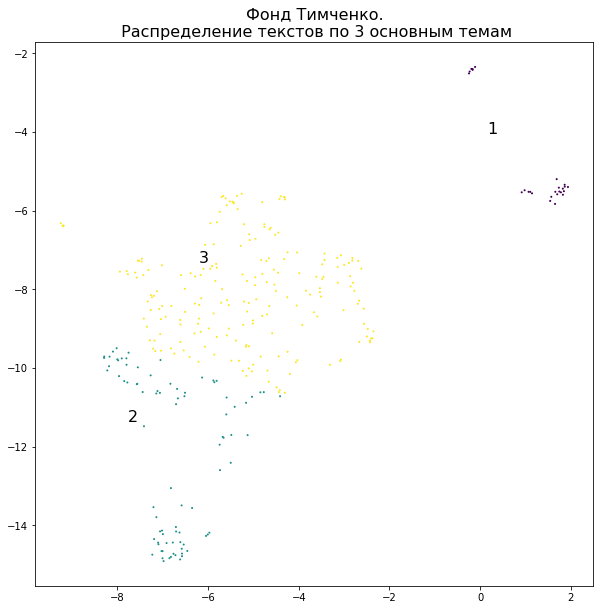

In [11]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=kmeans.labels_)
plt.title(f'Фонд Тимченко.\n Распределение текстов по {n_clusters} основным темам',size=16)

for k in range(len(centers)):
    mm = cupy.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = cupy.argmax(mm)
    top_word = tfidf.vocabulary_.iloc[ii]
    plt.text(centers[k,0]-1,centers[k,1]+0.75,f'{k+1}',size=16)
 
plt.show()

In [12]:
for k in range(n_clusters):
    mm = cupy.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = cupy.asnumpy( cupy.argsort(mm)[-5:][::-1] )
    top_words = tfidf.vocabulary_.to_array()[ii]
    print('#'*25)
    print(f'### Тема {k+1}')
    print('### Топ 5 Слов',top_words)
    print('#'*25)
    tmp = train_text_df.loc[train_text_df.cluster==k].sample(3, random_state=123)
    for j in range(3):
        txt = tmp.iloc[j,1]
        print('-'*10,f'Пример {j+1}','-'*10)
        print(txt,'\n')

#########################
### Тема 1
### Топ 5 Слов ['новоепоколение' 'фондтимченко' 'резьбаподереву' 'маджалис' 'foto']
#########################
---------- Пример 1 ----------
Тур по Гунибу, по Гамсутлю  От тур фирмы etnotur . Эрганайское водохранилище  . Скоро выложу полное видео  . А также можете подписаться на наш ютуб канал ссылка в шапке профиля 👆 . . . #новоепоколение #фондТимченко…   

---------- Пример 2 ----------
Из за прибрежных скал создаётся впечатление что море течет по ступенькам  . . . #новоепоколение #фондТимченко #море #siberia #argentina #резьбаподереву #маджалис #Dji #djmalik #djiphantom4 #djimavicair #djispark…   

---------- Пример 3 ----------
Селение призрак Гамсутль ⛰ Вчера ездили в тур  Гуниб  Гамсутль Скоро будет много интересного видео repost лайки комментарии приветствуются друзья не стесняйтесь 😊 Подержите групп 🤝 . . . #новоепоколение #фондТимченко…   

#########################
### Тема 2
### Топ 5 Слов ['елены' 'геннадия' 'благотворительный' 'тимченко

### Фонд "Подари жизнь"

In [13]:
"""Загружаем данные """
fond_data = data[data.fond_name == '"Подари жизнь"']
train_names = fond_data.id.to_list()
train_texts = fond_data.tweet.to_list()
train_text_df = cudf.DataFrame({'id': train_names, 'text': train_texts})
train_text_df.head()

,id,text
0,1436210423615853056,Ангелина в 13 лет хорошо разбирается в названи...
1,1435183032546299904,"Восемь прекрасных женщин рассказали, почему он..."
2,1432627263636446976,В Красноярске откроется отделение трансплантац...
3,1431264705851624960,"Здоровый образ жизни не спасет от рака, но рис..."
4,1431264604231974912,"Дарина сказала: «Живите так, как будто я рядом»"


In [14]:
"""Получение векторных представлений текстов"""

tfidf = TfidfVectorizer(stop_words=stopwords, binary=True, max_features=25_000)
text_embeddings = tfidf.fit_transform(train_text_df.text).toarray()

""" Понижение размерности"""
umap = UMAP()
embed_2d = umap.fit_transform(text_embeddings)
embed_2d = cupy.asnumpy( embed_2d )

In [15]:
n_clusters = 3
kmeans = cuml.KMeans(n_clusters=n_clusters)
kmeans.fit(embed_2d)
train_text_df['cluster'] = kmeans.labels_

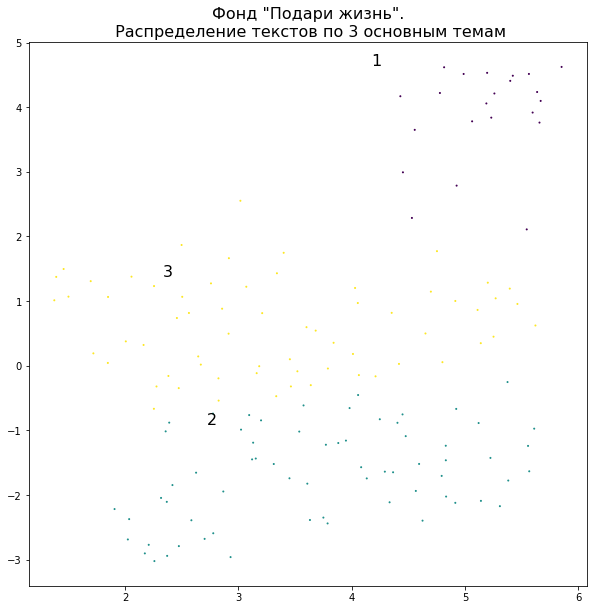

In [16]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=kmeans.labels_)
plt.title(f'Фонд "Подари жизнь".\n Распределение текстов по {n_clusters} основным темам',size=16)

for k in range(len(centers)):
    mm = cupy.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = cupy.argmax(mm)
    top_word = tfidf.vocabulary_.iloc[ii]
    plt.text(centers[k,0]-1,centers[k,1]+0.75,f'{k+1}',size=16)
    

plt.show()

In [17]:
for k in range(n_clusters):
    mm = cupy.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = cupy.asnumpy( cupy.argsort(mm)[-5:][::-1] )
    top_words = tfidf.vocabulary_.to_array()[ii]
    print('#'*25)
    print(f'### Тема {k+1}')
    print('### Топ 5 Слов',top_words)
    print('#'*25)
    tmp = train_text_df.loc[train_text_df.cluster==k].sample(3, random_state=123)
    for j in range(3):
        txt = tmp.iloc[j,1]
        print('-'*10,f'Пример {j+1}','-'*10)
        print(txt,'\n')

#########################
### Тема 1
### Топ 5 Слов ['год' 'рублей' 'фонда' 'миллиарда' 'известного']
#########################
---------- Пример 1 ----------
Дебиторская задолженность фонда «Подари жизнь», известного как фонд актрисы Чулпан Хаматовой, за 2021 год составила более одного миллиарда рублей.   

---------- Пример 2 ----------
Дебиторская задолженность фонда «Подари жизнь», известного как фонд актрисы Чулпан Хаматовой, за 2021 год составила более одного миллиарда рублей.   

---------- Пример 3 ----------
Дебиторская задолженность фонда «Подари жизнь», известного как фонд актрисы Чулпан Хаматовой, за 2021 год составила более одного миллиарда рублей.   

#########################
### Тема 2
### Топ 5 Слов ['podarizhizn' 'подари' 'жизнь' 'жизни' 'rarible']
#########################
---------- Пример 1 ----------
Благотворительные фонды, такие как Алеша, Подари жизнь, Линия жизни и другие. Что думаете?  

---------- Пример 2 ----------
L'actrice  Tchoulpane Khamatova @ChulpanH